# Lab08: Kernel Machines
## Mehmet Gönen
### April 22, 2022

In [1]:
import cvxopt as cvx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial.distance as dt

## Parameters

In [2]:
np.random.seed(421)
# mean parameters
class_means = np.array([[-4.0, +4.0],
                        [+4.0, -4.0],
                        [+2.0, +2.0],
                        [-2.0, -2.0],
                        [-4.0, -4.0],
                        [+4.0, +4.0],
                        [-2.0, +2.0],
                        [+2.0, -2.0]])
# covariance parameters
class_covariances = np.array([[[+0.4, +0.0],
                               [+0.0, +0.4]],
                              [[+0.4, +0.0],
                               [+0.0, +0.4]],
                              [[+0.8, -0.6], 
                               [-0.6, +0.8]],
                              [[+0.8, -0.6], 
                               [-0.6, +0.8]],                              
                              [[+0.4, +0.0],
                               [+0.0, +0.4]],
                              [[+0.4, +0.0],
                               [+0.0, +0.4]],
                              [[+0.8, +0.6], 
                               [+0.6, +0.8]],
                              [[+0.8, +0.6], 
                               [+0.6, +0.8]]])
# sample sizes
class_sizes = np.array([100, 100])

## Data Generation

In [3]:
# generate random samples
points1 = np.random.multivariate_normal(class_means[0,:], class_covariances[0,:,:], class_sizes[0] // 4)
points2 = np.random.multivariate_normal(class_means[1,:], class_covariances[1,:,:], class_sizes[0] // 4)
points3 = np.random.multivariate_normal(class_means[2,:], class_covariances[2,:,:], class_sizes[0] // 4)
points4 = np.random.multivariate_normal(class_means[3,:], class_covariances[3,:,:], class_sizes[0] // 4)
points5 = np.random.multivariate_normal(class_means[4,:], class_covariances[4,:,:], class_sizes[1] // 4)
points6 = np.random.multivariate_normal(class_means[5,:], class_covariances[5,:,:], class_sizes[1] // 4)
points7 = np.random.multivariate_normal(class_means[6,:], class_covariances[6,:,:], class_sizes[1] // 4)
points8 = np.random.multivariate_normal(class_means[7,:], class_covariances[7,:,:], class_sizes[1] // 4)
X = np.vstack((points1, points2, points3, points4, points5, points6, points7, points8))

# generate corresponding labels
y = np.concatenate((np.repeat(1, class_sizes[0]), np.repeat(0, class_sizes[1])))

## Exporting Data

In [4]:
# write data to a file
np.savetxt("lab08_data_set.csv", np.hstack((X, y[:, None])), fmt = "%f,%f,%d")

## Plotting Data

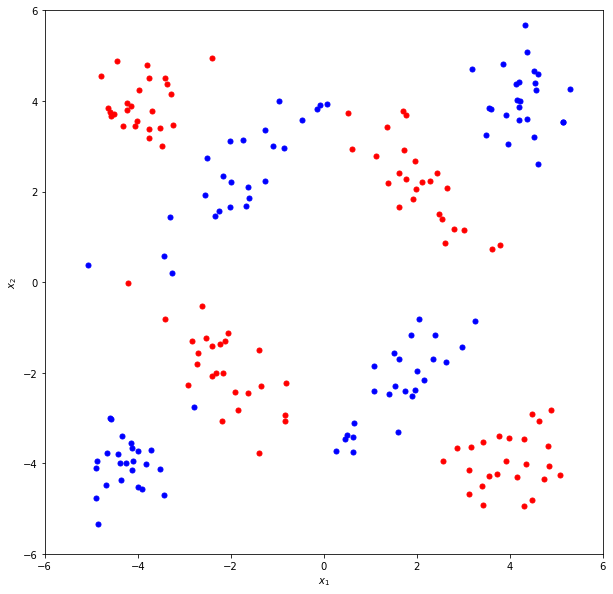

In [5]:
# plot data points generated
plt.figure(figsize = (10, 10))
plt.plot(X[y == 1, 0], X[y == 1, 1], "r.", markersize = 10)
plt.plot(X[y == 0, 0], X[y == 0, 1], "b.", markersize = 10)
plt.xlim((-6, +6))
plt.ylim((-6, +6))
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

## Importing Data

In [6]:
# read data into memory
data_set = np.genfromtxt("lab08_data_set.csv", delimiter = ",")

# get X and y values
X_train = data_set[:,[0, 1]]
y_train = 2 * data_set[:,2].astype(int) - 1

# get number of samples and number of features
N_train = len(y_train)
D_train = X_train.shape[1]

## Distance and Kernel Functions

$\begin{equation}
    \begin{split}
        d(\boldsymbol{x}_{i}, \boldsymbol{x}_{j}) &= ||\boldsymbol{x}_{i} - \boldsymbol{x}_{j}||_{2} = \sqrt{(\boldsymbol{x}_{i} - \boldsymbol{x}_{j})^{\top} (\boldsymbol{x}_{i} - \boldsymbol{x}_{j})} = \sqrt{\sum\limits_{d = 1}^{D}(x_{id} - x_{jd})^{2}} \\
        k(\boldsymbol{x}_{i}, \boldsymbol{x}_{j}) &= \exp\left(-\dfrac{||\boldsymbol{x}_{i} -\boldsymbol{x}_{j}||_{2}^{2}}{2s^{2}}\right)
    \end{split}
\end{equation}$

In [7]:
# define Gaussian kernel function
def gaussian_kernel(X1, X2, s):
    D = dt.cdist(X1, X2)
    K = np.exp(-D**2 / (2 * s**2))
    return(K)

## Learning Algorithm

#### Primal Problem
$\begin{equation}
	\begin{split}
		\mbox{minimize}\;\;& \dfrac{1}{2} ||\boldsymbol{w}||_{2}^{2} + C \sum\limits_{i = 1}^{N} \xi_{i} \\
		\mbox{with respect to}\;\;& \boldsymbol{w} \in \mathbb{R}^{D},\;\; \boldsymbol{\xi} \in \mathbb{R}^{N},\;\; w_{0} \in \mathbb{R} \\
		\mbox{subject to}\;\;& y_{i} (\boldsymbol{w}^{\top} \boldsymbol{x}_{i} + w_{0}) \geq 1 - \xi_{i} \;\;\;\; i = 1,2,\dots,N \\
		& \xi_{i} \geq 0\;\;\;\; i = 1,2,\dots,N \\
		\mbox{where}\;\;& C \in \mathbb{R}_{+}
	\end{split}
\end{equation}$

#### Dual Problem
$\begin{equation}
	\begin{split}
		\mbox{maximize}\;\;& \sum\limits_{i = 1}^{N} \alpha_{i} - \dfrac{1}{2} \sum\limits_{i = 1}^{N} \sum\limits_{j = 1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} k(\boldsymbol{x}_{i}, \boldsymbol{x}_{j}) \\
		\mbox{with respect to}\;\;& \boldsymbol{\alpha} \in \mathbb{R}^{N} \\
		\mbox{subject to}\;\;& \sum\limits_{i = 1}^{N} \alpha_{i} y_{i} = 0 \\
		& 0 \leq \alpha_{i} \leq C\;\;\;\; i = 1,2,\dots,N \\
		\mbox{where}\;\;& C \in \mathbb{R}_{+}
	\end{split}
\end{equation}$

#### Dual Problem in Matrix-Vector Form
$\begin{equation}
	\begin{split}
		\mbox{minimize}\;\;&-\boldsymbol{1}^{\top} \boldsymbol{\alpha} + \dfrac{1}{2} \boldsymbol{\alpha}^{\top} ((y y^{\top}) \odot \mathbf{K}) \boldsymbol{\alpha} \\
		\mbox{with respect to}\;\; & \boldsymbol{\alpha} \in \mathbb{R}^{N} \\
		\mbox{subject to}\;\;& \boldsymbol{y}^{\top} \boldsymbol{\alpha} = 0 \\
		& \boldsymbol{0} \leq \boldsymbol{\alpha} \leq C \boldsymbol{1} \\
		\mbox{where}\;\;& C \in \mathbb{R}_{+}
	\end{split}
\end{equation}$

In [8]:
# calculate Gaussian kernel
s = 1
K_train = gaussian_kernel(X_train, X_train, s)
yyK = np.matmul(y_train[:,None], y_train[None,:]) * K_train

# set learning parameters
C = 10
epsilon = 0.001

P = cvx.matrix(yyK)
q = cvx.matrix(-np.ones((N_train, 1)))
G = cvx.matrix(np.vstack((-np.eye(N_train), np.eye(N_train))))
h = cvx.matrix(np.vstack((np.zeros((N_train, 1)), C * np.ones((N_train, 1)))))
A = cvx.matrix(1.0 * y_train[None,:])
b = cvx.matrix(0.0)
                    
# use cvxopt library to solve QP problems
result = cvx.solvers.qp(P, q, G, h, A, b)
alpha = np.reshape(result["x"], N_train)
alpha[alpha < C * epsilon] = 0
alpha[alpha > C * (1 - epsilon)] = C

# find bias parameter
support_indices, = np.where(alpha != 0)
active_indices, = np.where(np.logical_and(alpha != 0, alpha < C))
w0 = np.mean(y_train[active_indices] * (1 - np.matmul(yyK[np.ix_(active_indices, support_indices)], alpha[support_indices])))

     pcost       dcost       gap    pres   dres
 0:  5.2317e+02 -5.3781e+03  9e+03  2e-01  4e-15
 1:  2.2702e+02 -6.5054e+02  1e+03  1e-02  2e-15
 2:  2.6883e+01 -1.8299e+02  2e+02  2e-03  2e-15
 3: -1.7754e+01 -1.0668e+02  9e+01  6e-04  1e-15
 4: -3.7793e+01 -5.7822e+01  2e+01  6e-05  1e-15
 5: -4.2330e+01 -4.8185e+01  6e+00  1e-05  1e-15
 6: -4.3986e+01 -4.5297e+01  1e+00  2e-06  1e-15
 7: -4.4466e+01 -4.4655e+01  2e-01  1e-07  1e-15
 8: -4.4542e+01 -4.4547e+01  5e-03  2e-09  1e-15
 9: -4.4545e+01 -4.4545e+01  7e-04  2e-10  1e-15
10: -4.4545e+01 -4.4545e+01  1e-05  2e-12  1e-15
Optimal solution found.


## Training Performance

In [9]:
# calculate predictions on training samples
f_predicted = np.matmul(K_train, y_train[:,None] * alpha[:,None]) + w0

# calculate confusion matrix
y_predicted = 2 * (f_predicted > 0.0) - 1
confusion_matrix = pd.crosstab(np.reshape(y_predicted, N_train), y_train,
                               rownames = ["y_predicted"], colnames = ["y_train"])
print(confusion_matrix)

y_train       -1    1
y_predicted          
-1           100    0
 1             0  100


## Visualization

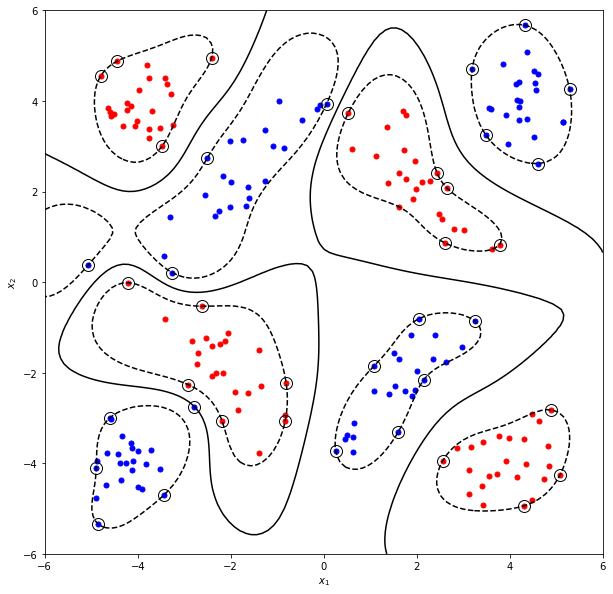

In [10]:
# evaluate discriminant function on a grid
x1_interval = np.linspace(-6, +6, 101)
x2_interval = np.linspace(-6, +6, 101)
x1_grid, x2_grid = np.meshgrid(x1_interval, x2_interval)
X_test = np.transpose(np.vstack((x1_grid.flatten(), x2_grid.flatten())))
K_test = gaussian_kernel(X_test, X_train, s)
discriminant_values = np.reshape(np.matmul(K_test, y_train[:,None] * alpha[:,None]) + w0, x1_grid.shape)

plt.figure(figsize = (10, 10))
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "r.", markersize = 10)
plt.plot(X_train[y_train == -1, 0], X_train[y_train == -1, 1], "b.", markersize = 10)
plt.plot(X_train[support_indices, 0], X_train[support_indices, 1], "ko", markersize = 12, fillstyle = "none")
plt.contour(x1_grid, x2_grid, discriminant_values, levels = [-1, 0, + 1], colors = "k", linestyles = ["dashed", "solid", "dashed"])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()